# Anomaly Segmentation

Mattia Gualandi \
0001125100 \
mattia.gualandi2@studio.unibo.it

## INITIALIZATION

Libraries installation and import

In [25]:
!pip install -q wandb
!pip install -q torchmetrics
! pip install -q torch torchvision

In [26]:
import os
import wandb
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import cv2 as cv
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import random
import shutil
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Dict, Any, Tuple, Any, Callable, Optional, Sequence
import copy
import torch
from torch import nn
from torch import Tensor
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification import JaccardIndex, Accuracy
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision.models.segmentation.deeplabv3 import ASPP
from torchvision import transforms as T
import torch.nn.functional as F
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import sklearn.metrics as sk
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

Fix random for reproducibility

In [27]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

Wandb project declaration

In [28]:
WANDB_USER = "your_wandb_username"
WANDB_PROJECT = "your_wandb_project_name"
os.environ["WANDB_API_KEY"] = "your_wandb_key"

wandb.login()

True

Drive mount

In [29]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get to current directory

In [30]:
os.chdir("/content/drive/MyDrive/anomaly_segmentation")

## UTILS

#### Dataset utils

Function to remove useless intermediate subdirectories by keeping the contents (in this case to remove the so called t1, t2, ..). The base function that has been modified to get this function has been used during hands on sessions.

In [31]:
def remove_subdirs_keep_contents(base_path: str, dirs: List[str]) -> int:
    """Removes sub-directories dirs inside the directory base_path,
       but keeps their contents in the parent directory.

    Args:
        base_path: the base path.
        dirs: the directories to delete.

    Returns:
        the number of deleted directories.
    """

    for dir in dirs:
        dir_path = Path(base_path) / dir

        if dir_path.exists() and dir_path.is_dir():
            # Move the contents of the directory to the base_path (parent directory)
            for item in dir_path.iterdir():
                shutil.move(str(item), base_path)

            # Remove the now-empty directory
            dir_path.rmdir()  # rmdir only removes empty directories

    return None

Function to compute labels distribution in the training set.

In [32]:
def compute_class_histograms(dataloader):

    class_histograms = Counter()
    for images, labels in tqdm(dataloader, desc="Computing class histograms"):
        labels = labels.squeeze(1)
        labels = labels.cpu().numpy().flatten()
        class_histograms.update(labels)

    return dict(class_histograms)

Function to compute class weights based on the inverse frequency of the labels in the training set.

In [33]:
def compute_class_weights(dataloader, num_classes):
    #Counts initialization
    class_pixels_counts = np.zeros(num_classes, dtype=np.int64)

    for _, masks in tqdm(dataloader):
        # Check unique labels in the batch and count them
        label, batch_count = np.unique(masks, return_counts=True)
        # Update pixels' counts for ech class
        if len(batch_count) == num_classes:
            class_pixels_counts += batch_count
        else:
            for lbl, count in zip(label, batch_count):
                class_pixels_counts[lbl-1] += count

    total_pixels = np.sum(class_pixels_counts)

    class_weights = []

    # Compute weights for each class
    for i in range(num_classes):
        weight_for_i = (1 / class_pixels_counts[i]) * (total_pixels / num_classes)
        class_weights.append(weight_for_i)

    return torch.tensor(class_weights, dtype=torch.float32)

#### Visualization utils

Function to visualize closed set segmentation, it plots the original image, the ground truth segmentation and the predicted one.

In [34]:
def visualize_prediction_closed_set(image, label, model, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    # Get model's predictions
    image = image.to(device)
    label = label.to(device)
    prediction, _ = model(image)
    prediction = nn.Upsample(size=(720, 1280), mode='bilinear', align_corners=False)(prediction)
    prediction = prediction.argmax(1)
    # Put image, label and prediction on cpu
    image = image.cpu()
    label = label.cpu()
    prediction = prediction.cpu()

    # Plot images, ground truth labels and predicted ones
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze().permute(1, 2, 0).numpy())
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(label.squeeze().numpy(), cmap="gray")
    plt.title("True Label")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze().cpu().numpy(), cmap="gray")
    plt.title("Predicted Label")

    plt.show()

Function to visualize scores distribution of correctly classified in-distribution pixels vs anomalous ones.

In [35]:
def plot_scores_distributions(scores, labels, predictions, num_classes = 13):
    labels_flat = labels.cpu().flatten()
    scores_flat = scores.cpu().flatten()
    predictions_flat = predictions.cpu().flatten()
    anomaly_class = 13

    normal_scores = scores_flat[(labels_flat != anomaly_class) & (predictions_flat == labels_flat)]
    anomaly_scores = scores_flat[(labels_flat == anomaly_class)]

    # Plot distributions
    sns.histplot(normal_scores, color="blue", label="Normal", kde=True, bins=50)
    sns.histplot(anomaly_scores, color="red", label="Anomaly", kde=True, bins=50)
    plt.yscale('function', functions=(np.sqrt, np.square))
    plt.legend()
    plt.title(f"Distribution of in and out of distribution scores")
    plt.show()

Function to display the anomaly scores heatmap on the image. The function also plots the original image and the ground truth segmentation.

In [36]:
def plot_anomaly_scores(original_image, scores, anomaly_map_gt):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image.cpu().permute(1, 2, 0))
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(scores.cpu().squeeze(), cmap="coolwarm")
    plt.title("Scores")

    plt.subplot(1, 3, 3)
    plt.imshow(anomaly_map_gt.squeeze(), cmap="gray")
    plt.title("Ground truth Anomaly Mask")
    plt.show()

Function to convert the grey scale segmentation to colors.

In [37]:
"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""

COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2,
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4,
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6,
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9,
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11,
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
])


def color(annot_path: str, colors: np.ndarray) -> Image.Image:
    img_pil = Image.open(annot_path)
    img_np = np.array(img_pil)
    img_new = np.zeros((720, 1280, 3))

    for index, color in enumerate(colors):
        img_new[img_np == index + 1] = color

    return Image.fromarray(img_new.astype("uint8"), "RGB")

#### Metrics utils

Functions taken from the mentioned source to compute open set metrics, namely AUROC, AUPR, and FPR-95.

In [38]:
"""
Source: https://github.com/hendrycks/anomaly-seg/blob/master/anom_utils.py
"""

def stable_cumsum(arr, rtol=1e-05, atol=1e-08):
    """Use high precision for cumsum and check that final value matches sum
    Parameters
    ----------
    arr : array-like
        To be cumulatively summed as flat
    rtol : float
        Relative tolerance, see ``np.allclose``
    atol : float
        Absolute tolerance, see ``np.allclose``
    """
    out = np.cumsum(arr, dtype=np.float64)
    expected = np.sum(arr, dtype=np.float64)
    if not np.allclose(out[-1], expected, rtol=rtol, atol=atol):
        raise RuntimeError('cumsum was found to be unstable: '
                           'its last element does not correspond to sum')
    return out

def fpr_and_fdr_at_recall(y_true, y_score, recall_level=0.95, pos_label=None):
    classes = np.unique(y_true)
    if (pos_label is None and
            not (np.array_equal(classes, [0, 1]) or
                     np.array_equal(classes, [-1, 1]) or
                     np.array_equal(classes, [0]) or
                     np.array_equal(classes, [-1]) or
                     np.array_equal(classes, [1]))):
        raise ValueError("Data is not binary and pos_label is not specified")
    elif pos_label is None:
        pos_label = 1.

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = stable_cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps      # add one because of zero-based indexing

    thresholds = y_score[threshold_idxs]

    recall = tps / tps[-1]

    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)      # [last_ind::-1]
    recall, fps, tps, thresholds = np.r_[recall[sl], 1], np.r_[fps[sl], 0], np.r_[tps[sl], 0], thresholds[sl]

    cutoff = np.argmin(np.abs(recall - recall_level))

    return fps[cutoff] / (np.sum(np.logical_not(y_true)))   # , fps[cutoff]/(fps[cutoff] + tps[cutoff])

def get_measures(_pos, _neg, recall_level=0.95):
    pos = np.array(_pos[:]).reshape((-1, 1))
    neg = np.array(_neg[:]).reshape((-1, 1))
    examples = np.squeeze(np.vstack((pos, neg)))
    labels = np.zeros(len(examples), dtype=np.int32)
    labels[:len(pos)] += 1

    auroc = sk.roc_auc_score(labels, examples)
    aupr = sk.average_precision_score(labels, examples)
    fpr = fpr_and_fdr_at_recall(labels, examples, recall_level)

    return auroc, aupr, fpr

#### Statistical utils

Function to compute mean and std from training set logits per class to implement standardized max logits method.

In [39]:
def compute_mean_std_per_class(model, dataloader, num_classes, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    # Initialize accumulators
    class_sums = defaultdict(float)
    class_squared_sums = defaultdict(float)
    class_counts = defaultdict(int)

    # Loop through the dataloader
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            # Get model outputs
            outputs, _ = model(images)  # Assuming outputs are logits
            outputs = nn.Upsample(size=(720, 1280), mode='bilinear', align_corners=False)(outputs)
            probs = F.softmax(outputs, dim=1)  # Get probabilities
            preds = torch.argmax(probs, dim=1)  # Predicted class

            # Loop through each class
            for cls in range(num_classes):
                # Get mask for current class
                class_mask = (labels == cls) & (preds == cls)
                if class_mask.sum() == 0:
                    continue

                # Extract probabilities for the correctly classified pixels of this class
                class_probs = probs[class_mask, cls]

                # Update accumulators for Welford's algorithm
                class_sums[cls] += class_probs.sum().item()
                class_squared_sums[cls] += (class_probs ** 2).sum().item()
                class_counts[cls] += class_mask.sum().item()

    # Calculate mean and std for each class
    class_means = {}
    class_stds = {}
    for cls in range(num_classes):
        if class_counts[cls] > 0:
            mean = class_sums[cls] / class_counts[cls]
            variance = (class_squared_sums[cls] / class_counts[cls]) - (mean ** 2)
            std = torch.sqrt(torch.tensor(variance)).item()
            class_means[cls] = mean
            class_stds[cls] = std
        else:
            class_means[cls] = float('nan')
            class_stds[cls] = float('nan')

    return class_means, class_stds


#### Validation utils

Function to perform cosed set inference on the validation set computing IoU and pixel accuracy.

In [40]:
def validate_model(model, val_loader, criterion, num_classes, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    model.eval()
    iou_metric = JaccardIndex(num_classes=num_classes, task = 'multiclass').to(device)
    accuracy_metric = Accuracy(num_classes=num_classes, task="multiclass").to(device)
    losses = []
    val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device).long()

            outputs, _ = model(images)
            outputs = nn.Upsample(size=(720, 1280), mode='bilinear', align_corners=False)(outputs)

            labels = labels.squeeze(1)
            labels = torch.clamp(labels, 0, num_classes - 1)

            loss = criterion
            loss = loss(outputs, labels)
            losses.append(loss.item())

            # Convert predictions to class labels
            outputs = nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            # Update metrics
            iou_metric.update(preds, labels)
            accuracy_metric.update(preds, labels)

        # Compute average loss, IoU and pixel accuracy
        avg_loss = sum(losses) / len(losses)
        mean_iou = iou_metric.compute().item()
        mean_accuracy = accuracy_metric.compute().item()

    # Reset the IoU metric for the next evaluation
    iou_metric.reset()
    accuracy_metric.reset()
    return mean_iou, mean_accuracy, avg_loss


#### Test utils

Function to get the anomaly scores from the model using the desired technique.

In [41]:
def get_scores(outputs, mode='entropy', device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    if mode not  in ["custom", "entropy", "max logits", "energy", "standardized max logits"]:
        raise ValueError("Mode not supported")

    if mode == "custom":
        """
        Source: https://openaccess.thecvf.com/content/CVPR2021W/SAIAD/papers/Fontanel_Detecting_Anomalies_in_Semantic_Segmentation_With_Prototypes_CVPRW_2021_paper.pdf
        """
        max_scores, predictions = torch.max(outputs, dim=1)
        scores = (max_scores + 10.)/(20.) # Original numbers were 1 and 2 but a scaler =10 is applied during training so they become 10 and 20
        scores = 10 - scores
        scores = scores.cpu()

    elif mode == "entropy":
        T = 2.  # Temperature parameter
        softmax_probs = F.softmax(outputs / T, dim=1)
        scores = scipy.stats.entropy(softmax_probs.cpu(), axis=1)
        scores = torch.from_numpy(scores)
        _, predictions = torch.max(softmax_probs, dim=1)

    elif mode == "max logits":
        max_scores, predictions = torch.max(outputs, dim=1)
        scores = -max_scores
        scores = scores.cpu()

    elif mode == "energy":
        T = 2.
        scores = -torch.logsumexp(outputs.cpu() / T, dim=1)
        softmax_probs = F.softmax(outputs / T, dim=1)
        _, predictions = torch.max(softmax_probs, dim=1)

    elif mode == "standardized max logits":
        # Load statistics
        stats_dict = torch.load("/content/drive/MyDrive/anomaly_segmentation/weights/scores_stats.pt", weights_only = True)
        class_means = stats_dict["scores_means"].to(device)
        class_stds = torch.sqrt(stats_dict["scores_stds"]).to(device)

        # Compute max logits and corresponding predicted classes
        max_logits, predictions = torch.max(outputs, dim=1)

        # Flatten for easy indexing
        max_logits_flat = max_logits.view(-1)
        predictions_flat = predictions.view(-1)

        valid_classes = (predictions_flat >= 0) & (predictions_flat < len(class_means))
        standardized_logits = torch.zeros_like(max_logits_flat)

        if valid_classes.any():
            mean_vals = class_means[predictions_flat[valid_classes]]
            std_vals = class_stds[predictions_flat[valid_classes]]

            std_vals = torch.where(std_vals > 0, std_vals, torch.tensor(1.0, device=device))  # Avoid division by zero
            standardized_logits[valid_classes] = (max_logits_flat[valid_classes] - mean_vals) / std_vals

        # Reshape back to spatial dimensions
        scores = -standardized_logits.view(max_logits.shape).cpu()

    return scores, predictions

Function to perform full test set inference, getting scores according tho the desired method and then computing metrics.
Note that the best way to compute such kind of metrics would be to use the whole dataset scores, but since this is unfeasile the measures are approximated using the mean of the values computed on the largest fitting batch. The averaging approach has been used also in the code used as source, so it can be considered a reliable approximation.

In [42]:
def test_metrics(dataloader, model, mode = "entropy", anomaly_class = 13, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.eval()
    auprs = []
    fprs = []
    aurocs =[]

    #Raise error for unsupported configurations
    if mode == "custom" and isinstance(model.deeplab.classifier, Classifier):
        raise ValueError('Mode not supported for the model')

    if mode == "standardized max logits" and isinstance(model.deeplab.classifier, CosineClassifier):
        raise ValueError('Mode not supported for the model')

    with torch.no_grad():
        for images, labels in tqdm(dataloader):

            # Get outputs
            images = images.to(device)
            binary_lab = labels == anomaly_class
            outputs, _ = model(images)
            outputs = nn.Upsample(size=(720, 1280), mode='bilinear', align_corners=False)(outputs)

            # Get scores according to the desired method
            scores, _ = get_scores(outputs, mode=mode)

            # Compute metrics
            auroc, aupr, fpr95  = get_measures(scores[binary_lab].flatten(), scores[~binary_lab].flatten())

            aurocs.append(auroc)
            auprs.append(aupr)
            fprs.append(fpr95)

            del images, labels, binary_lab, outputs, scores
            torch.cuda.empty_cache()

    return fprs, aurocs, auprs


## DATA PREPARATION

In [43]:
DATA_PATH = "/content/drive/MyDrive/anomaly_segmentation/data/"

Data folders extraction and subdirectories cleaning.

In [44]:
!tar -xf "/content/drive/MyDrive/anomaly_segmentation/data/streethazards_train.tar" -C "data"
!tar -xf "/content/drive/MyDrive/anomaly_segmentation/data/streethazards_test.tar" -C "data"

In [45]:
# Remove useless folder keeping their content for easier access
remove_subdirs_keep_contents(DATA_PATH + "train/images/training", ["t1-3"])
remove_subdirs_keep_contents(DATA_PATH + "train/images/validation", ["t4"])
remove_subdirs_keep_contents(DATA_PATH + "test/images/test", ["t5", "t6"])

remove_subdirs_keep_contents(DATA_PATH + "train/annotations/training", ["t1-3"])
remove_subdirs_keep_contents(DATA_PATH + "train/annotations/validation", ["t4"])
remove_subdirs_keep_contents(DATA_PATH + "test/annotations/test", ["t5", "t6"])

## DATASET

StreetHazards dataset creation and loading

In [46]:
class StreetHazardsDataset(Dataset):
    def __init__(self, root_dir, data_split, transform=None, target_transform=None, crop_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = sorted([os.path.join(root_dir, "images/" + data_split, f) for f in os.listdir(os.path.join(root_dir, "images/" + data_split))])
        self.label_paths = sorted([os.path.join(root_dir, "annotations/" + data_split, f) for f in os.listdir(os.path.join(root_dir, "annotations/" + data_split))])
        self.crop_size = crop_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = Image.open(self.label_paths[idx])

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Variables and transformation definition.

Note that, even though it is usually a good practice to normalize according to pretrained dataset means and variances, in this case it has been proven that both qualitatively and quantitatively this was not the best choice; indeed the images became overly dark at first sight and the performance also were worse then the non normalized version.

Also, due to the intrinsic high computational load of the training, not many epochs were manageable, so since data augmentation would have required many more epochs to give the desired effects, then it is not performed.

For this reason no particular transformations have been performed.

In [47]:
# Define dataset paths
train_dir = DATA_PATH + "train"
test_dir = DATA_PATH + "test"

# Define transformations
transform = T.Compose([
    T.ToTensor(),
])

target_transform = T.Compose([
    T.Lambda(lambda x: torch.from_numpy(np.array(x)-1)),
])

The batch size is small to avoid gpu memory problems during training, on the other hand, just for the testing part, the largest possible batch size is chosen to make the open-set metrics computation more robust (since theoretically they should be computed on the whole test set scores, even tough it is unfeasible for resources limitations).

In [48]:
batch_size = 4
# Load datasets
train_dataset = StreetHazardsDataset(train_dir, data_split= "training", transform=transform, target_transform=target_transform)
val_dataset = StreetHazardsDataset(train_dir, data_split= "validation", transform=transform, target_transform=target_transform)
test_dataset = StreetHazardsDataset(test_dir, data_split= "test", transform=transform, target_transform=target_transform)

# DataLoader for exploration and training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Below, the plot of the labels' distribution in the training set.

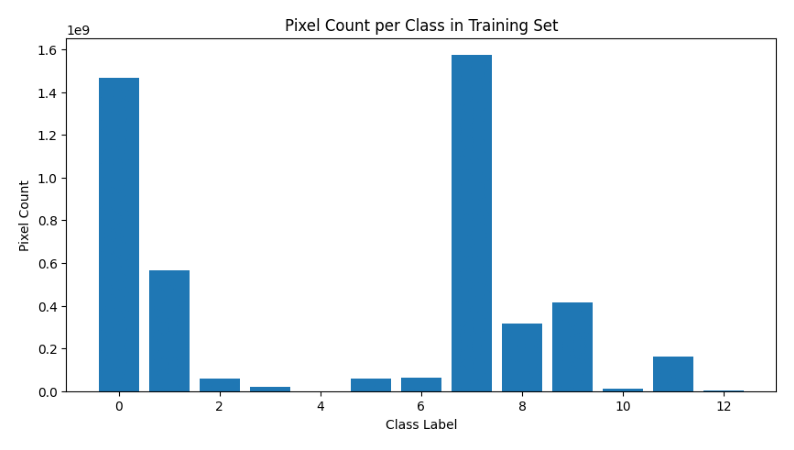

In [49]:
img = mpimg.imread("/content/drive/MyDrive/anomaly_segmentation/images/class_distribution.png")

plt.figure(figsize=(10,7))
plt.imshow(img)
plt.axis('off')
plt.show()


As evident from the image the dataset is really imbalanced, as it could be predictable being street scenes dominated by some particular classes (e.g sky, road, ...). While others such as, pedestrians, traffic signs and so on are overly underrepresented being generally less frequent in images but also smaller/ thinner, having in general much less pixels even when present in the image.

For this reason class weights have been computed to be tried for training, see results later. (Weights are saved in the weights folder but not needed to reproduce this particular configuration of the notebook).

## NETWORK

The final network used for the task is based on pretrained DeepLabV3. It keeps the backbone using the ResNet101 and the ASPP module as well. The classifier is changed to adapt to the desired number of classes and to anomaly segmentation task.
The used classifier, in fact, is a cosine classifier that proved to better suit the anomaly segmentation task.

In addition to that, also lower level features are processed separately via convolution and used for training, this chain will be called deepsupervision from now on and it is not used at inference time.

Just ASPP module's parameters, classifier's ones, and low level features convolution are set as trainable.

In [50]:
num_classes = 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Classifiers declaration, both a regular one as well as the cosine one are created for ablation studies.
If deepsup argument is set to true the model uses lower level features from backbone's layer to to use further representation for training. The classifier code is taken from the cited source.

In [51]:
"""
Source: https://github.com/DarioFontanel/PAnS/blob/main/modules/classifier.py
"""

class Classifier(nn.Module):
    def __init__(self, channels, classes, deepsup=False):
        super(Classifier, self).__init__()
        self.channels = channels
        self.classes = classes
        self.cls = nn.Conv2d(channels, classes, 1)

        self.deepsup = deepsup
        if deepsup:
            self.cls_deepsup = nn.Conv2d(channels, classes, 1, 1, 0)

    def forward(self, x, x_deepsup):
        logits_deepsup = self.cls_deepsup(x_deepsup) if self.deepsup else None
        logits = self.cls(x)

        return logits, logits_deepsup

class CosineClassifier(nn.Module):
    def __init__(self, channels, classes, deepsup=False):
        super().__init__()
        self.channels = channels
        self.scaler = 10.
        self.classes = classes
        self.tot_classes = 0

        self.cls = nn.Conv2d(channels, classes, 1, bias=False)

        self.deepsup = deepsup

        if deepsup:
            self.cls_deepsup = nn.Conv2d(channels, classes, 1, 1, 0, bias=False)

    def forward(self, x, x_deepsup):
        out = F.normalize(x, p=2, dim=1)
        logits = self.scaler * F.conv2d(out, F.normalize(self.cls.weight, dim=1, p=2))

        if self.deepsup:
            out = F.normalize(x_deepsup, p=2, dim=1)
            logits_deepsup = self.scaler * F.conv2d(out, F.normalize(self.cls_deepsup.weight, dim=1, p=2))
        else:
            logits_deepsup = None

        return logits, logits_deepsup

def get_classifier(classifier_type):
    if classifier_type == 'standard':
        return Classifier
    elif classifier_type == 'cosine':
        return CosineClassifier

Model declaration

In [52]:
class AnomalySegmentation(nn.Module):
    def __init__(self, num_classes=13, classifier_type='cosine', deepsup=False):
        super(AnomalySegmentation, self).__init__()

        self.deepsup =deepsup
        # Baseline model
        self.deeplab = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
        # ASPP module
        self.aspp = ASPP(in_channels=2048, atrous_rates=[12, 24, 36], out_channels=512)
        # Classifier
        self.deeplab.classifier = get_classifier(classifier_type=classifier_type)(channels=512, classes=num_classes, deepsup=deepsup)

        # If deepsup, then lower level feaetures from Resnet's layer 2 are processed and used for deepsupervision training
        if self.deepsup:
            self.low_level_conv = nn.Conv2d(512, 512, kernel_size=1, bias=False)
            self.low_level_bn = nn.BatchNorm2d(512)
            self.low_level_drop = nn.Dropout2d(0.1)

        # Set trainable layers
        # Freeze all layers
        for param in self.parameters():
            param.requires_grad = False

        # Unfreeze the trainable layers
        for param in self.deeplab.classifier.parameters():
            param.requires_grad = True
        for param in self.aspp.parameters():
            param.requires_grad = True
        # Unfreeze low level processing if deepsupervision is activated
        if self.deepsup:
            for param in self.low_level_conv.parameters():
                param.requires_grad = True
            for param in self.low_level_bn.parameters():
                param.requires_grad = True

    def forward(self, x):

        # If deepsup, extract manually features from backbone's layer 2 and process them
        if self.deepsup:
            # Extract features
            low_level_features = self.deeplab.backbone.conv1(x)
            low_level_features = self.deeplab.backbone.bn1(low_level_features)
            low_level_features = self.deeplab.backbone.relu(low_level_features)
            low_level_features = self.deeplab.backbone.maxpool(low_level_features)
            low_level_features = self.deeplab.backbone.layer1(low_level_features)
            low_level_features = self.deeplab.backbone.layer2(low_level_features)
            # Process features
            low_level_features = self.low_level_conv(low_level_features)
            low_level_features = self.low_level_bn(low_level_features)
            low_level_features = self.low_level_drop(low_level_features)
        else:
            low_level_features = None

        # Regular path
        high_level_features = self.deeplab.backbone(x)['out']
        # Pass backbone features to ASPP and process them again
        high_level_features = self.aspp(high_level_features)

        # Pass features trough the classifier
        x, x_deepsup = self.deeplab.classifier(high_level_features, low_level_features)

        return x, x_deepsup


In [53]:
model = AnomalySegmentation(num_classes = num_classes, classifier_type='cosine', deepsup=True)
model.eval()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 154MB/s]


## TRAINER

Trainer definition, for training configuration is the following:
- AdamW optimzer
- Onecycle scheduler for learning rate from 1e-5 to 1e-4
- Pixel accuracy and IoU metrics for training and validation


In [54]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            device: torch.device,
            num_classes: int,
            criterion: Tuple,
            cfg: Dict[str, Any]
        ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        self.criterion = criterion
        num_steps = self.num_epochs * len(self.train_loader)
        self.scheduler = OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)

        self.step = 0

        wandb.init(name=cfg["run_name"], project=WANDB_PROJECT, config=cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:

        self.model.train()

        for epoch in range(self.num_epochs):
            running_loss = 0.0
            print(f"Epoch [{epoch+1}/{self.num_epochs}]")

            # Initialize metrics for IoU and pixel accuracy
            iou_metric = JaccardIndex(num_classes=num_classes, task="multiclass").to(device)
            accuracy_metric = Accuracy(num_classes=num_classes, task="multiclass").to(device)

            train_loader_tqdm = tqdm(self.train_loader, desc="Training", leave=False)

            for images, labels in train_loader_tqdm:
                # Check whether the batch, namely the last has just one element
                if images.shape[0] == 1:
                    continue
                images, labels = images.to(device), (labels).long().to(device)

                # Get model's output
                outputs, output_deep = self.model(images)
                outputs = nn.Upsample(size=(labels.shape[1], labels.shape[2]), mode='bilinear', align_corners=False)(outputs)

                if self.model.deepsup:
                    outputs_deep = nn.Upsample(size=(720, 1280), mode='bilinear', align_corners=False)(output_deep)

                labels = labels.squeeze(1)

                # Initialize and compute the loss for the regular and deepsup outputs
                loss = self.criterion
                loss_reg = loss(outputs, labels)

                if self.model.deepsup:
                    loss_deep = loss(outputs_deep, labels)
                else:
                    loss_deep = 0

                loss = loss_reg + loss_deep

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward(retain_graph=True)
                self.optimizer.step()
                self.scheduler.step()

                running_loss += loss.item()

                # Convert predictions to class labels
                outputs = nn.functional.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)

                # Update metrics
                iou_metric.update(preds, labels)
                accuracy_metric.update(preds, labels)

                # Compute batch metrics
                batch_iou = iou_metric.compute().item()
                batch_accuracy = accuracy_metric.compute().item()

                # Wandb logs
                if self.step % 5 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/batch_IoU": batch_iou})
                    self.logfn({"train/batch_accuracy": batch_accuracy})
                    self.logfn({"train/total_loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})

                self.step += 1

                # Print metrics for the current batch
                train_loader_tqdm.set_postfix(
                    loss=loss.item(), iou=batch_iou, accuracy=batch_accuracy
                )

                # Reset metrics for the next batch and clean memory
                iou_metric.reset()
                accuracy_metric.reset()

                del images, labels, outputs, preds, loss, loss_reg
                if self.model.deepsup:
                    del loss_deep
                torch.cuda.empty_cache()

            print(f"Training Loss: {running_loss/len(train_loader):.4f}")

            # Validation after each epoch
            self.eval()

        wandb.finish()

    @torch.no_grad()
    def eval(self) -> None:
        self.model.eval()
        iou_metric = JaccardIndex(num_classes=num_classes, task = 'multiclass').to(device)
        accuracy_metric = Accuracy(num_classes=num_classes, task="multiclass").to(device)
        losses = []
        val_loader_tqdm = tqdm(self.val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for images, labels in val_loader_tqdm:
                images, labels = images.to(device), labels.to(device).long()

                # In validation inference only regular outputs are used, not the deepsupervision ones
                outputs, _ = self.model(images)
                outputs = nn.Upsample(size=(720, 1280), mode='bilinear', align_corners=False)(outputs)

                labels = labels.squeeze(1)

                loss = self.criterion
                loss = loss(outputs, labels)

                losses.append(loss)

                # Convert predictions to class labels
                outputs = nn.functional.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)

                # Update metrics
                iou_metric.update(preds, labels)
                accuracy_metric.update(preds, labels)

                # Compute batch metrics
                batch_iou = iou_metric.compute().item()
                batch_accuracy = accuracy_metric.compute().item()

                del images, labels, outputs, preds, loss

            # Compute average loss, IoU and pixel accuracy over the validation set
            avg_loss = sum(losses) / len(losses)
            mean_iou = iou_metric.compute().item()
            mean_accuracy = accuracy_metric.compute().item()

            print(f'Validation Iou: {mean_iou}')
            print(f'Validation Accuracy: {mean_accuracy}')
            print(f"Validation Loss: {avg_loss:.4f}")

        # Reset the IoU metric for the next evaluation
        iou_metric.reset()
        accuracy_metric.reset()


Trainer configuration

In [55]:
cfg = {
    "lr": 1e-4,
    "wd": 1e-4,
    "num_epochs": 2
}

Loss definition, the used loss is regular cross-entropy for fine-tuning to stick to a common choice according to many papers on the topic.
Also some other auxiliary losses, such as dice loss, have been tried without performance improvement.

In [56]:
criterion = nn.CrossEntropyLoss(ignore_index=-1)

## TRAIN

Training loop if the train varibale is set to true, final model's weights load otherwise.

In [57]:
TRAIN = False

In [58]:
if TRAIN:
    cfg["run_name"] = "cosclass_deepfeat_weighted"
    trainer = Trainer(
        model,
        train_loader,
        val_loader,
        device,
        num_classes,
        criterion,
        cfg=cfg
    )

    trainer.train()
    torch.save(model.state_dict(), f"weights_{cfg['run_name']}_{cfg['num_epochs']}epochs.pt")
else:
    model.load_state_dict(torch.load("/content/drive/MyDrive/anomaly_segmentation/weights/weights_ce_cosclass_deepfeat_2epoch.pt", weights_only=True))

## CLOSED SET RESULTS VISUALIZATION AND METRICS COMPUTATION

Segmentation visualization and metrics computation on validation set images

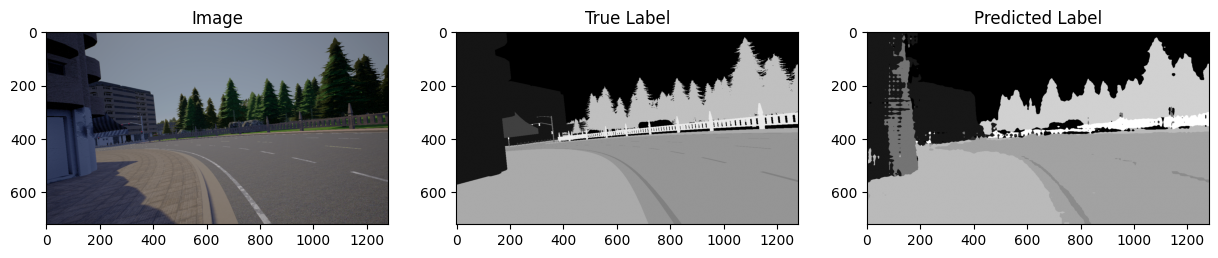

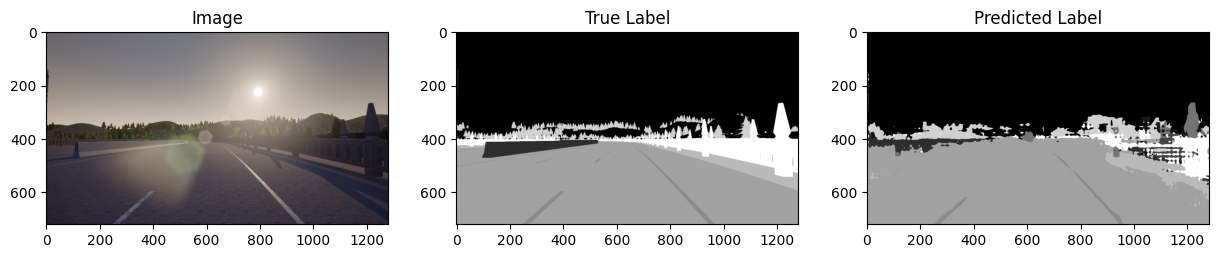

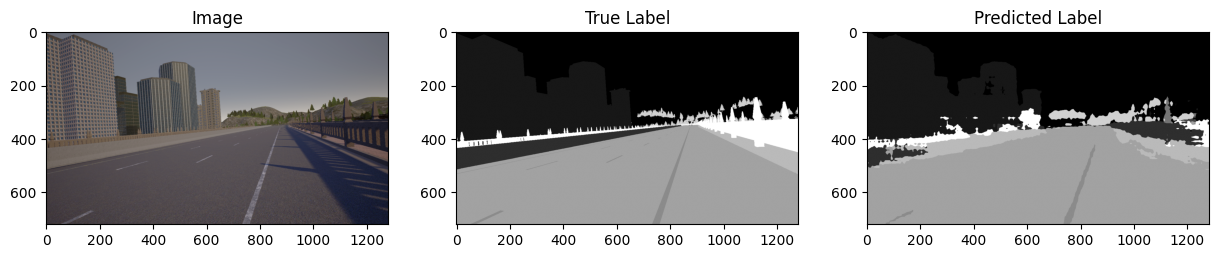

In [59]:
model.eval()
with torch.no_grad():
    for idx in [10, 40, 200]:
        image, label = val_dataset[idx]
        image = image.unsqueeze(0)
        visualize_prediction_closed_set(image, label, model)

Metrics computation for closed set segmentation on validation set

In [60]:
# Change to true to compute metrics on validation test
VALIDATION = False

In [61]:
if VALIDATION:
    miou, mean_acc, avg_loss = validate_model(model, val_loader, criterion, num_classes, device)
    print("Closed set segmentation metrics on validation set")
    print(miou)
    print(mean_acc)
    print(avg_loss)

The model produces, qualitatively speaking, decently good results, showing more difficulties in particular classes, generally the underepresented ones, and on far objects.
Still it gets:
- IoU = 0.49
- Pixel accuracy = 89%

## OPEN SET INFERENCE, METRICS COMPUTATION AND RESULTS VISUALIZATION

For inference, to get anomaly scores from outputs, the best choice proved to be entropy based scoring computed on temperature scaled softmax apllied to model's outputs, please note that due to the nature of the classfier the output from the model represent the similarities with the known classes; so higher entropy on the scores means that there is no clear similarity to none of the in distribution classes.

In [62]:
fprs, aurocs, auprs = test_metrics(test_loader, model, mode="entropy", anomaly_class=13)
print("Open set metrics for anomaly segmentation")
print("FPR-95", np.array(fprs).mean())
print("AUROC", np.array(aurocs).mean())
print("AUPR", np.array(auprs).mean())

Visualization of anomaly scores

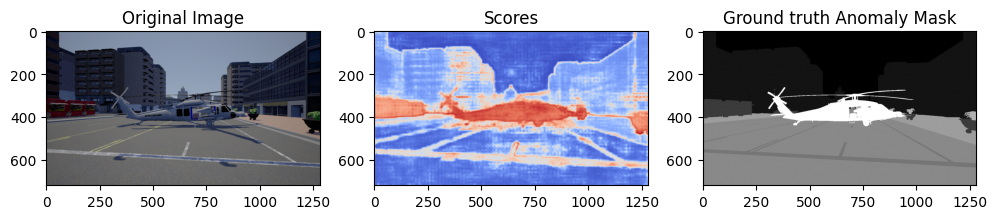

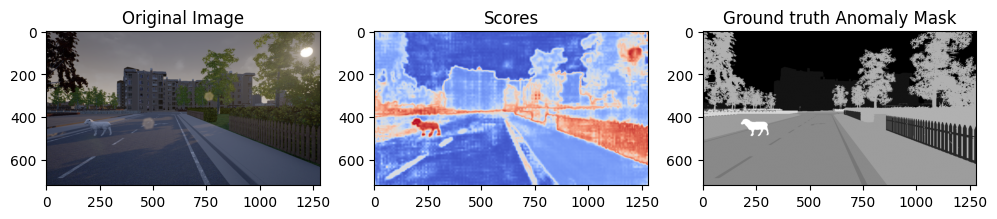

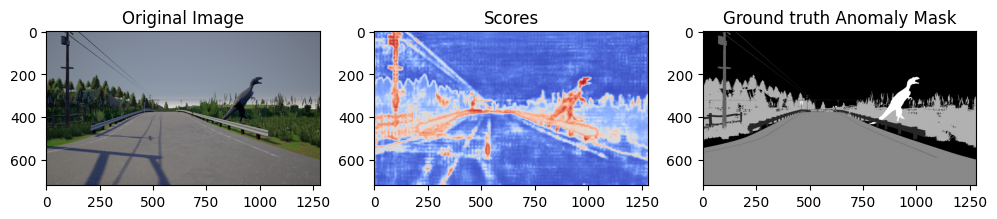

In [63]:
idxs_to_visualize =[30, 31, 32]
with torch.no_grad():
    for idx in idxs_to_visualize:
        image, label = test_dataset[idx]

        outputs, _ = model(image.unsqueeze(0).to(device))
        outputs = nn.Upsample(size=(720, 1280), mode='bilinear', align_corners=False)(outputs)

        scores, _ = get_scores(outputs, mode="entropy")

        plot_anomaly_scores(image, scores, label)


Visually, scores are pretty well representing anomalies, still as anticipated, some uncertainty is present on some underrepresented class (e.g. fence, traffic signs in this case).

## ABLATION

To reach the just shown final model some other configurations have been tried throughout the process.

The training have been performed using deepfeatures and cosine classifier, as in the final model, removing deepsupervision, switching the cosine classifier with a standard one, and adding class weights to cross-entropy loss during training.

For the first three mentioned configurations, the training curves didn't show particular differencies between each other, while the last one exhibited a substantial drop in training performances, as shown in the following image.





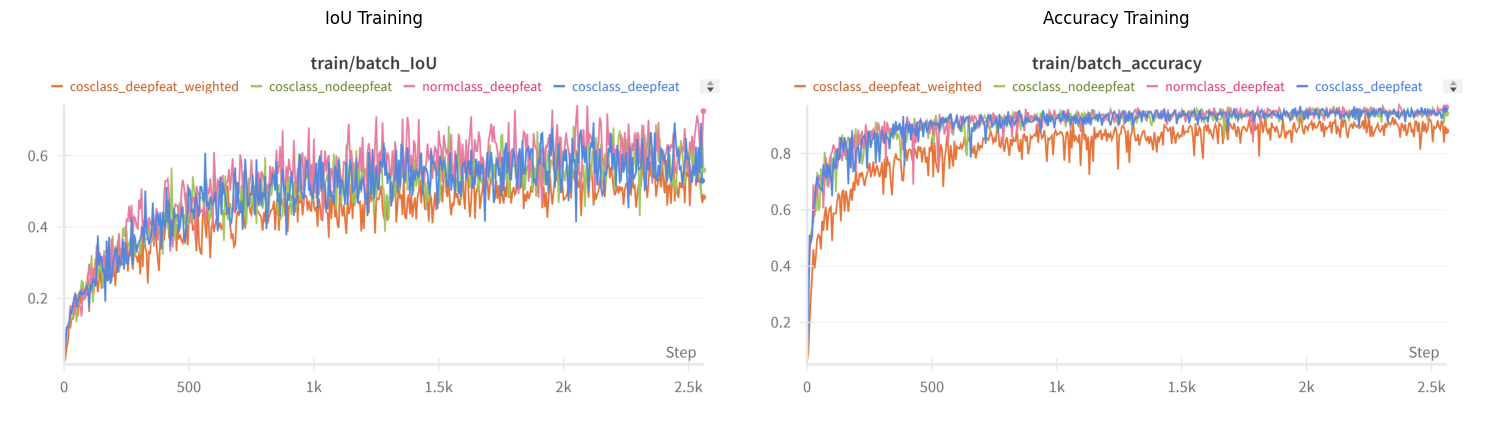

In [64]:
img1 = mpimg.imread("/content/drive/MyDrive/anomaly_segmentation/images/iou_training.png")
img2 = mpimg.imread("/content/drive/MyDrive/anomaly_segmentation/images/accuracy_training.png")

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('IoU Training')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Accuracy Training')
plt.tight_layout()
plt.show()

The configuration run with class weights, being evidently worse than the other ones is dropped for further analysis.

As anticipated the other three training curves are pretty much comparable looking at training graphs; then, inspecting deeperly their performances on validation set some differences emerged.

Indeed the metrics obtained on the validation split are the following:

\begin{array}{c|c|c|c}
    & \text{Cosine Classifier} \atop \text{w/ Deepsupervision} &  \text{Standard Classifier} \atop \text{w/ Deepsupervision}  &  \text{Cosine Classifier} \atop \text{w/out Deepsupervision} \\
    \hline
    \text{IoU} & 0.49 & 0.51 & 0.43\\
    \text{Pixel Accuracy}  & 88.9 & 88.9 & 85.0\\
\end{array}

Given these results, the removal of deepsupervision in not considered anymore in further inspections and confirms the impact of deepsupervision on model's performance.

Let's now have a better look at how the final model with two different classifier's configurations perform at inference using some shared methods and some peculiar ones for each model. (Inference cells for all the configurations are not reported, being too time consuming to be run all together, still all the configuration can be tried using the cell below).

In [65]:
# Change to true to test one of the configurations
INFERENCE_ABLATION = False
MODEL_TO_TEST = "cosine" # Pick one between "cosine" and "standard"
MODE = "entropy" # Pick one between "entropy", "max logits", "custom", "energy" and "standardized max logits"

In [66]:
if INFERENCE_ABLATION:
    if MODEL_TO_TEST in ["cosine", "standard"]:
        weights_name = "weights_ce_cosclass_deepfeat_2epoch.pt" if MODEL_TO_TEST == "cosine" else "weights_ce_normclass_deepfeat_2epoch.pt"
        model = AnomalySegmentation(num_classes = num_classes, classifier_type=MODEL_TO_TEST, deepsup=True)
        model.eval()
        model.to(device)
        model.load_state_dict(torch.load("/content/drive/MyDrive/anomaly_segmentation/weights/" + weights_name, weights_only=True))
    else:
        raise ValueError("Model to test is not supported")

    fprs, aurocs, auprs = test_metrics(test_loader, model, mode=MODE, anomaly_class=13)
    print("Open set metrics for anomaly segmentation")
    print("FPR-95", np.array(fprs).mean())
    print("AUROC", np.array(aurocs).mean())
    print("AUPR", np.array(auprs).mean())


Below, a metrics table is shown for the considered approaches, namely the model with cosine classifier and with standard classifier. The columns for each model represent the method used to get anomaly scores:
- Max logits simply takes the highest score for each pixel, in both models the higher it is the most confident the model is about it belonging to in distribution pixels, for this reason the scores are computed as the negative of themselves, namely $ scores = - max\_logits $.

- Entropy is computed on temperature scaled softmax probability for both the models, in this case the higher the entropy the more likely the pixel to be an anomalous one, also in this case this method is applied to both the models.

- Energy is computed approximating the max with the logsumexp to make the scoring function smoother with respect to raw max logits, in this case again the higher the energy the more likely is the anomaly. This method is just tried for the cosine classfier, showing not excellent results, still it is suitable for standard classifier too.

- Custom is computed taking the idea from the paper where cosine classifier is used and computes the score as $ score = 1 - max(s_i) $ where $ s_i = \frac{logit_i + 1}{2} $. It is meant for the cosine classifier so it is used just for the first model. In this case, for the cosine classifier, the results are approximately equal to max logits evaluation since this custom metrics is just based on max logits themselves with just scaling and additive parameters.

- For the standard classifier model the standardized max logits method is used taking inspiration from $ "https://arxiv.org/pdf/2107.11264" $. Scores are standardized according to means and standard deviations computed on the training set and the scores represent the distance from the distribution.
This method is not suited for cosine classifier so it is used just for the second model.


\begin{array}{c|ccc|ccc}
    & & \text{Cosine Classifier} & & & \text{Standard Classifier} & \\
    \hline
    & \text{Energy} & \text{Entropy} & \text{Custom /} \atop \text{Max Logits} & \text{Max Logits} & \text{Entropy} &  \text{Standardized} \atop \text{Max Logits}  \\
    \hline
    \text{FPR-95} & 24.4 & 24.7 & 25.2 & 26.9 & 26.5 & 24.0 \\
    \text{AUROC}  & 91.8 & 92.4 & 91.9 & 91.5 & 91.5 & 92.2 \\
    \text{AUPR}   & 9.2 & 15.8 & 11.9 & 12.5 & 11.7 & 12.6 \\
\end{array}

Generally, all the configurations produced decent results, aligned with the results obtained by state of the art publications on the StreetHazard dataset.

On average cosine classifier perform slightly better, even though the best configuration of standard classifier has good performance too.

Still, even if the model with the standard classifier shows solid performance in terms of closed set metrics, even better than the final proposed model; still when dealing with open set segmentation it demonstrate to be slightly less effective.
By inspecting results, indeed, the reason emerged and is about how scores are distributed.

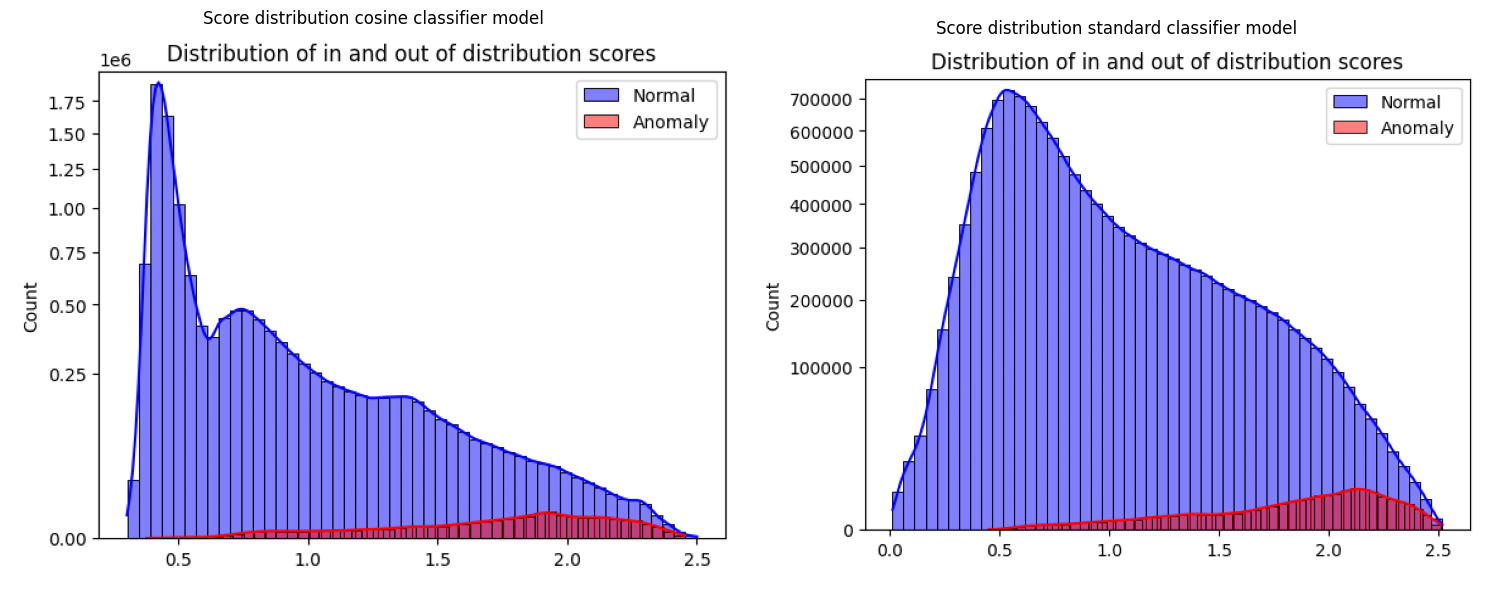

In [67]:
img1 = mpimg.imread("/content/drive/MyDrive/anomaly_segmentation/images/score_distribution_cosclass.png")
img2 = mpimg.imread("/content/drive/MyDrive/anomaly_segmentation/images/score_distribution_stdclass.png")

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Score distribution cosine classifier model')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Score distribution standard classifier model')
plt.tight_layout()
plt.show()

In the above plots scores of correctly classified in-distribution pixels are labeled in blue, while anomalous pixels are in red. Y-scale is square root scale for better visualization.

As shown, even if the two distributions are in none of the cases separable, in the case of cosine classifier the distribution of known classes is much more skewed and peaked toward left while in the other case the distribution is less skewed toward left. This proves what was anticipated previously, in fact the difference in performance on open set inference is due to this and proves how, considering the same scoring method, cosine classifier is able to better separate in and out of distribution classes. It seems not a case that the best performing method for standard classifier, which is just slightly worse thank the best model, is indeed the one that aims at increasing separability by standardizing values per class (as explained in the cited paper) .

## CONCLUSIONS

In the end, satisfactory results aligned with state of the art results on StreetHazard dataset are reached, even considering a low computational budget scenario in which the project has been carried on. The experiments proved how anomaly detection is affected not only on purely classification performance but mainly to classes representation and deep "understanding" of classes themselves.

Observing the evidence obtained during the study, the main difficulties in the process have been to deal with poorly represented classes or far backgrounds where objects are less clearly distinguishable.

Given these reasons, possible further developments, given the possibilty to access more computational power, may try to address these problems by for instance augmenting the dataset using crops (for zooming far background and focus on underrepresented classes, which are often small or thin object that may be less relevant when taking the whole image). Also, in such a scenario, the addition of class weights during training may better impact training itself.
Lastly, still if computational resorces allowed it, trying more advanced (and in general more expensive) models with respect to cosine classifier, to be trained for separability of classes may be tried (e.g contrastive loss, ...).

A final visualization of segmented images considered above is shown (threshold is now handpicked from scores visualization).

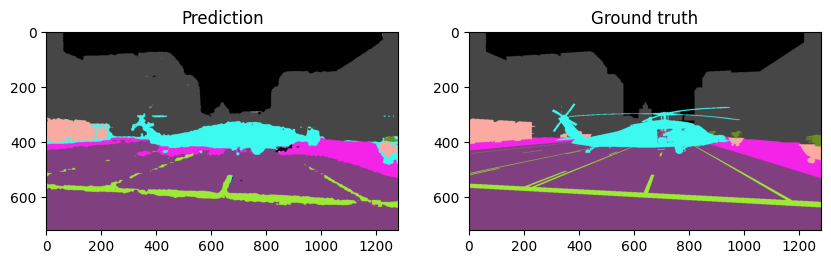

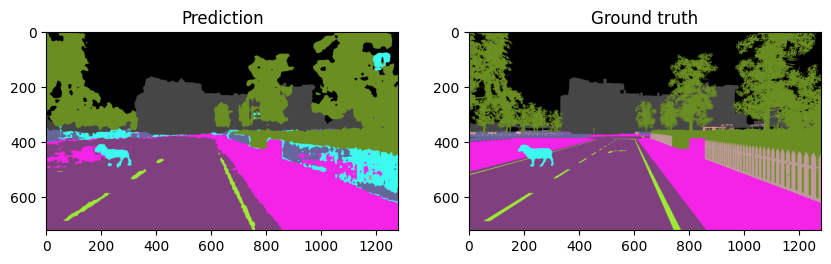

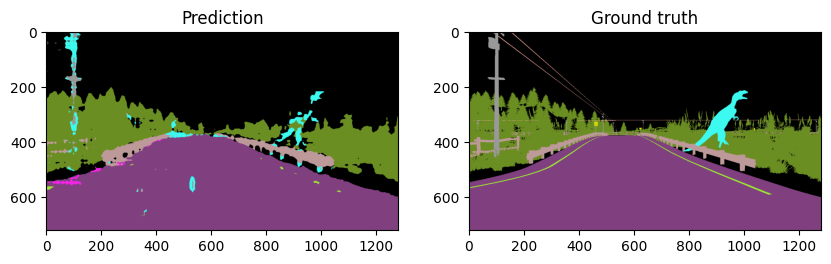

In [68]:
idxs_to_visualize =[30, 31, 32]
with torch.no_grad():
    for idx in idxs_to_visualize:
        image, label = test_dataset[idx]

        outputs, _ = model(image.unsqueeze(0).to(device))
        outputs = nn.Upsample(size=(720, 1280), mode='bilinear', align_corners=False)(outputs)

        scores, _ = get_scores(outputs, mode="entropy")
        scores = scores.squeeze(0).cpu().numpy()

        _, mask = torch.max(outputs, dim=1)
        mask= mask.squeeze(0).cpu().numpy()

        mask[scores > 2] = 13

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(COLORS[mask])
        plt.title("Prediction")

        plt.subplot(1, 2, 2)
        plt.imshow(COLORS[label])
        plt.title("Ground truth")

        plt.show()

